In [302]:
#Used following coding on MAC terminal as provided by Chris Bruehl on 3/23/21

#sqlite3 mta.db

## Create the table
#CREATE TABLE mta_data (
#	CA TEXT,
#	UNIT TEXT,
#	SCP TEXT,
#	STATION TEXT,
#	LINENAME TEXT,
#	DIVISION TEXT,
#	DATE TEXT,
#	TIME TEXT,
#	DESC TEXT,
#	ENTRIES INTEGER,
#	EXITS INTEGER,
#	PRIMARY KEY (CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS));


In [303]:
#Ran once in python

#import urllib.request

#url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
#week_nums = [190803, 190810, 190817, 190824,190831, 190907, 190914, 190914, 190921,
#190928, 191005, 191012, 191019, 191026]

#for week_num in week_nums:
#    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
#                               f"turnstile_{week_num}.txt")

In [304]:
##More from Chris Bruehl on 3/23/21

## Combine them into one big csv to load into sqlite from MAC terminal
# head -1 turnstile_210313.txt > all_combined.csv
# tail -n +2 -q *.txt >> all_combined.csv

# Go back to sqlite tab; load the big csv into sqlite
#.mode csv
#.import data/all_combined.csv mta_data 

In [305]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')

In [306]:
engine = create_engine("sqlite:///mta.db")

In [307]:
all_tables = engine.table_names()
all_tables

['mta_data']

In [308]:
df = pd.read_sql('SELECT * FROM mta_data WHERE LINENAME = "4" or LINENAME = "5" or LINENAME = "6" or LINENAME = "25" or LINENAME = "BD";'
                 , engine)

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323899 entries, 0 to 323898
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   CA        323899 non-null  object
 1   UNIT      323899 non-null  object
 2   SCP       323899 non-null  object
 3   STATION   323899 non-null  object
 4   LINENAME  323899 non-null  object
 5   DIVISION  323899 non-null  object
 6   DATE      323899 non-null  object
 7   TIME      323899 non-null  object
 8   DESC      323899 non-null  object
 9   ENTRIES   323899 non-null  int64 
 10  EXITS     323899 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 27.2+ MB


In [310]:
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME,format="%m/%d/%Y %H:%M:%S")

In [311]:
df.sort_values(['STATION','CA','UNIT','SCP','DATE','TIME'], ascending = False)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
319990,R419,R326,00-05-01,ZEREGA AV,6,IRT,10/25/2019,21:00:00,REGULAR,39,160,2019-10-25 21:00:00
319989,R419,R326,00-05-01,ZEREGA AV,6,IRT,10/25/2019,17:00:00,REGULAR,39,160,2019-10-25 17:00:00
319988,R419,R326,00-05-01,ZEREGA AV,6,IRT,10/25/2019,13:00:00,REGULAR,39,160,2019-10-25 13:00:00
319987,R419,R326,00-05-01,ZEREGA AV,6,IRT,10/25/2019,09:00:00,REGULAR,39,160,2019-10-25 09:00:00
319986,R419,R326,00-05-01,ZEREGA AV,6,IRT,10/25/2019,05:00:00,REGULAR,39,160,2019-10-25 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
9442,R252,R180,00-00-00,103 ST,6,IRT,07/27/2019,17:00:00,REGULAR,33962,32933,2019-07-27 17:00:00
9441,R252,R180,00-00-00,103 ST,6,IRT,07/27/2019,13:00:00,REGULAR,33541,32608,2019-07-27 13:00:00
9440,R252,R180,00-00-00,103 ST,6,IRT,07/27/2019,09:00:00,REGULAR,33122,32266,2019-07-27 09:00:00
9439,R252,R180,00-00-00,103 ST,6,IRT,07/27/2019,05:00:00,REGULAR,32917,32010,2019-07-27 05:00:00


In [312]:
df[["PREV_DATE","PREV_TIME","PREV_DATE_TIME","PREV_ENTRIES", "PREV_EXITS"]] = (df
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])[["DATE", "TIME", "DATE_TIME", "ENTRIES","EXITS"]]
                                                       .apply(lambda grp: grp.shift(1)))

In [313]:
df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [314]:
def get_dif_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

#using 10,000 entries per period as maximum allowed
df["DIFF_ENTRIES"]= df.apply(get_dif_entries, axis=1, max_counter=10000)

8 299598.0
109924314 1928952353.0
1124011719 12447170.0
26 113956.0
1035 351699.0
9 550801.0
569319988 779190.0
33600558 189253.0
507 3676614.0
221 302163.0
8 3319600.0
4 2013355776.0
102 17970.0
425 17298359.0
139431285 1325952663.0
1870 5391681.0
248 326895.0
3584 253120.0
285275072 1162483.0
127 437251.0
230 110114.0
30 9112633.0
268447449 1063972.0


In [315]:
def get_dif_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["EXITS"], row["PREV_ENTRIES"])
        return 0
    return counter
#using 10,000 entries per period as maximum allowed
df["DIFF_EXITS"]= df.apply(get_dif_exits, axis=1, max_counter=10000)

0 299598.0
114870601 1928952353.0
1979715859 12447170.0
3 113956.0
379 351699.0
3 550801.0
569320459 779190.0
53392 189253.0
122 3676614.0
645 302163.0
65 3319600.0
3 2013355776.0
71 17970.0
66 17298359.0
171921348 1325952663.0
405 5391681.0
96 326895.0
485 253120.0
301995385 1162483.0
44 437251.0
266 110114.0
17 9112633.0
100725926 1063972.0


In [316]:
df["PER_TRAFFIC"] = df["DIFF_ENTRIES"] + df["DIFF_EXITS"]

In [317]:
df['DAY_WEEK'] = df['DATE_TIME'].dt.dayofweek
# Week days = 0 - 4

In [318]:
line_station = (df.groupby(["LINENAME","STATION",],as_index=False).PER_TRAFFIC.sum())

In [319]:
line_station.set_index("STATION", drop=True, append=False, inplace=True,)

In [320]:
#Eliminating stations included that are not in Bronx
line_station.drop(index=['PRESIDENT ST','STERLING ST','WINTHROP ST','CHURCH AV','BEVERLY RD','NEWKIRK AV','FLATBUSH AV-B.C'],inplace=True)
line_station.drop(index=['77 ST','96 ST','103 ST','110 ST','116 ST','51 ST','33 ST','28 ST','23 ST','ASTOR PL','SPRING ST','ORCHARD BEACH','GRAND ST'],inplace=True)

In [321]:
line_station.head()

,LINENAME,PER_TRAFFIC
STATION,,
174 ST,25,1021317.0
219 ST,25,362165.0
225 ST,25,441725.0
233 ST,25,466696.0
3 AV-149 ST,25,2400953.0


In [322]:
weekly_line_station = line_station.nsmallest(10, ['PER_TRAFFIC'])
weekly_line_station['WEEKLY_AVG'] = weekly_line_station["PER_TRAFFIC"]/13

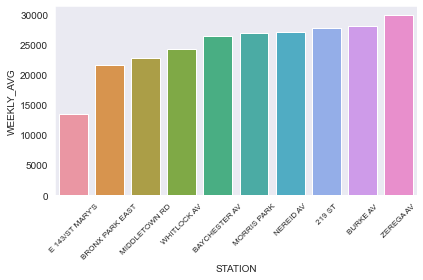

In [323]:
sns.barplot(x = weekly_line_station.index, y="WEEKLY_AVG",data=weekly_line_station)
plt.xticks(rotation=45,fontsize=8)
plt.tight_layout()
#plt.title('WEEKLY AVERAGE TRAFFIC FOR LOWEST 10 BRONX STATIONS', fontsize = 10)
plt.savefig('LOW10STATIONS.PNG');

In [324]:
line4 = line_station[line_station["LINENAME"] == "4"]
line4["WEEKLY_AVG"] = line4["PER_TRAFFIC"]/13
line4 = line4.nsmallest(11, ['PER_TRAFFIC'])

<ipython-input-324-7540d554661c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line4["WEEKLY_AVG"] = line4["PER_TRAFFIC"]/13


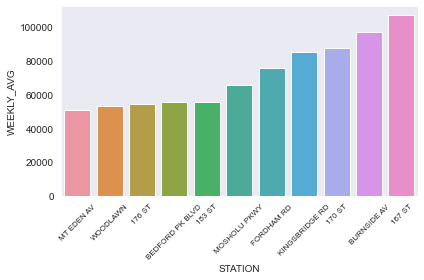

In [325]:
sns.barplot(x = line4.index, y="WEEKLY_AVG",data=line4)
plt.xticks(rotation=45,fontsize=8)
plt.tight_layout()
plt.savefig('STATIONS_LINE4.PNG');

In [326]:
weekly_line = (line_station.groupby(["LINENAME"],as_index=False).PER_TRAFFIC.sum())

In [327]:
weekly_line["LINE_AVG_WEEKLY"] = weekly_line["PER_TRAFFIC"]/13

In [328]:
weekly_line.head()

,LINENAME,PER_TRAFFIC,LINE_AVG_WEEKLY
0,25,13851945.0,1.065534e+06
1,4,10231457.0,7.870352e+05
2,5,2263978.0,1.741522e+05
3,6,18065730.0,1.389672e+06
4,BD,8319254.0,6.399426e+05


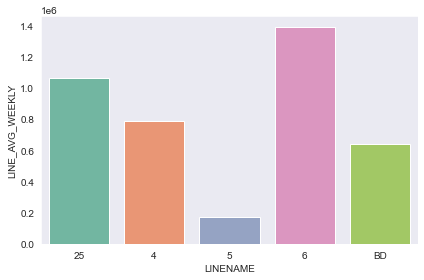

In [329]:
sns.barplot(x = "LINENAME", y="LINE_AVG_WEEKLY",data=weekly_line)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.savefig('BRONX_LINE.PNG');